# 1. All image csv

In [9]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv


# 2. Single hospital image csv

In [10]:
import csv
import os
from collections import defaultdict

def filter_hospital_data(input_csv_path, target_hospital_ids):
    patient_data = defaultdict(list)

    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    hospital_55_data = []
    for images in patient_data.values():
        hospital_55_data.extend(images)

    return hospital_55_data

# Input and output paths
input_csv_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
output_folder = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital'
# Single hospital id
target_hospital_ids = ['18']

# Get data for hospital 55
hospital_55_data = filter_hospital_data(input_csv_path, target_hospital_ids)

# Write hospital 55 data to CSV file
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

# Save hospital 55 data to 'hospital55.csv'
write_to_csv(os.path.join(output_folder, 'hospital18.csv'), hospital_55_data)

print("Saved single hospital csv.")


Saved single hospital csv.


# Functions

training class weight [0.7590361445783133, 1.4651162790697674]
Image location: /local/data1/honzh073/data/8bit_down224/patient_ZMABDXMOMB_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NJBJGFVKBJ_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_PSJSXBDWKK_hospital_18_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_TZEUFZULSM_hospital_18_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_XWVGPALIEE_hospital_18_NFF_image_3.png


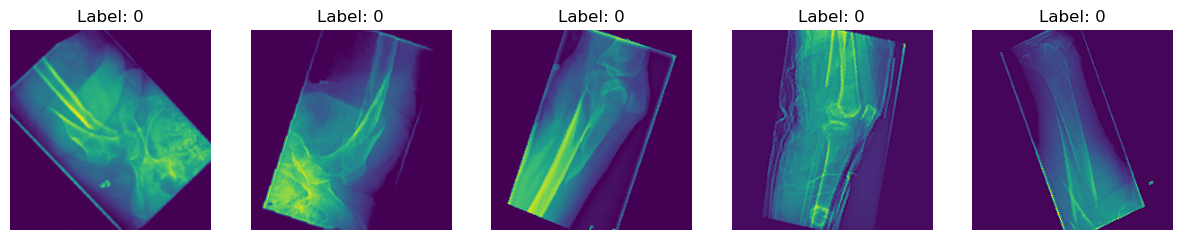

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 43, ratio: 0.34
----- NFF: 83, ratio: 0.66
-----------------------------------


In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
from torchvision import transforms, models
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
   
def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff


# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
from torchvision import transforms

# augmentation
# augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/hospital18.csv', transform=train_transforms)
# test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# print images
show_image(train_dataset, 5)

# calculate numbers
print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
# test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
# test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
# print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
# print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
# ------------------------------------------------------------------------------------------------------
def train_custom_model(model, train_dataset, num_epochs, batch_size, optimizer=None):
    classweight = get_classweight(train_dataset) # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):
        print(f'Fold {fold + 1}/{n_splits}')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train

            model.eval()
            correct_validation = 0
            total_validation = 0
            validation_loss = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    validation_loss += loss.item()

            validation_accuracy = 100 * correct_validation / total_validation
            validation_loss /= len(val_loader)

            print(f"Epoch {epoch+1}/{num_epochs}, "
                f"train ACC: {train_accuracy:.2f}%, "
                f"Val ACC: {validation_accuracy:.2f}%")
    return model  # Return the trained model after training is complete
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from torch.utils.data import Dataset
from PIL import Image
import csv
from torchvision import transforms, models
import json

import random
import torch.optim as optim
from torch.optim import lr_scheduler


# 设置随机数种子
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# 设置CUDA随机数种子（如果使用GPU）
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# json train
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['ImagePath']
        label = item['Label']

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to numerical representation
        if label == 'NFF':
            label = 0
        elif label == 'AFF':
            label = 1
        else:
            raise ValueError("Invalid label in JSON data.")

        return image, label
    
# csv
class CustomCsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.hospital_ids = []  # Store hospital IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                hospital_id = row['HospitalID']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)
                self.hospital_ids.append(int(hospital_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff

def test_model(model, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = correct_test_nff / total_nff if total_nff != 0 else 0
    test_accuracy_aff = correct_test_aff / total_aff if total_aff != 0 else 0
    test_accuracy_total = (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_predictions)

    # Calculate Matthew's correlation coefficient
    mcc_score = matthews_corrcoef(all_labels, all_predictions)

    # Calculate F1 score
    f1_score_value = f1_score(all_labels, all_predictions)

    # Store metrics in a dictionary
    metrics = {
        # "Test Loss": round(test_loss, 3),
        "Total Acc": round(test_accuracy_total, 3),
        "nff Acc": round(test_accuracy_nff, 3),
        "aff Acc": round(test_accuracy_aff, 3),
        "AUC": round(auc_score, 3),
        "MCC": round(mcc_score, 3),
        "F1 Score": round(f1_score_value, 3),
    }

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_rep)

    return metrics
# ------------------------------------------------------------------------------------------------------


# VGG 19

In [13]:
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

v19 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# vgg19_metrics = test_model(model, test_dataset, batch_size=8)
# print(vgg19_metrics)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 59.00%, Val ACC: 50.00%
Epoch 2/20, train ACC: 45.00%, Val ACC: 65.38%
Epoch 3/20, train ACC: 62.00%, Val ACC: 61.54%
Epoch 4/20, train ACC: 58.00%, Val ACC: 65.38%
Epoch 5/20, train ACC: 64.00%, Val ACC: 53.85%
Epoch 6/20, train ACC: 70.00%, Val ACC: 57.69%
Epoch 7/20, train ACC: 63.00%, Val ACC: 61.54%
Epoch 8/20, train ACC: 70.00%, Val ACC: 61.54%
Epoch 9/20, train ACC: 58.00%, Val ACC: 65.38%
Epoch 10/20, train ACC: 55.00%, Val ACC: 69.23%
Epoch 11/20, train ACC: 73.00%, Val ACC: 80.77%
Epoch 12/20, train ACC: 64.00%, Val ACC: 69.23%
Epoch 13/20, train ACC: 82.00%, Val ACC: 65.38%
Epoch 14/20, train ACC: 71.00%, Val ACC: 50.00%
Epoch 15/20, train ACC: 63.00%, Val ACC: 61.54%
Epoch 16/20, train ACC: 51.00%, Val ACC: 65.38%
Epoch 17/20, train ACC: 63.00%, Val ACC: 73.08%
Epoch 18/20, train ACC: 73.00%, Val ACC: 53.85%
Epoch 19/20, train ACC: 66.00%, Val ACC: 61.54%
Epoch 20/20, train ACC: 75.00%, Val ACC: 73.08%
Fold 2/5
Epoch 1/20, train ACC: 64.36%, 

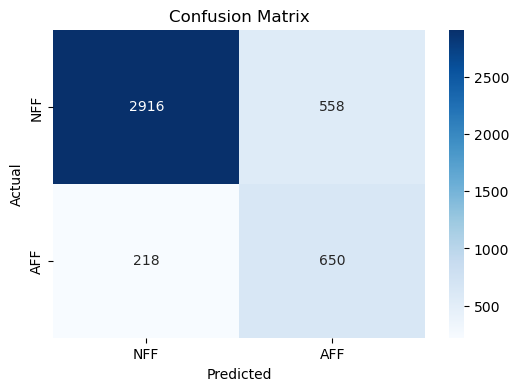

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3474
           1       0.54      0.75      0.63       868

    accuracy                           0.82      4342
   macro avg       0.73      0.79      0.75      4342
weighted avg       0.85      0.82      0.83      4342



{'Total Acc': 0.821,
 'nff Acc': 0.839,
 'aff Acc': 0.749,
 'AUC': 0.794,
 'MCC': 0.525,
 'F1 Score': 0.626}

In [14]:
model = v19
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet50

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 67.00%, Val ACC: 61.54%
Epoch 2/20, train ACC: 65.00%, Val ACC: 65.38%
Epoch 3/20, train ACC: 76.00%, Val ACC: 61.54%
Epoch 4/20, train ACC: 70.00%, Val ACC: 69.23%
Epoch 5/20, train ACC: 80.00%, Val ACC: 73.08%
Epoch 6/20, train ACC: 69.00%, Val ACC: 76.92%
Epoch 7/20, train ACC: 84.00%, Val ACC: 65.38%
Epoch 8/20, train ACC: 82.00%, Val ACC: 73.08%
Epoch 9/20, train ACC: 83.00%, Val ACC: 73.08%
Epoch 10/20, train ACC: 89.00%, Val ACC: 80.77%
Epoch 11/20, train ACC: 84.00%, Val ACC: 80.77%
Epoch 12/20, train ACC: 83.00%, Val ACC: 84.62%
Epoch 13/20, train ACC: 91.00%, Val ACC: 88.46%
Epoch 14/20, train ACC: 94.00%, Val ACC: 84.62%
Epoch 15/20, train ACC: 94.00%, Val ACC: 80.77%
Epoch 16/20, train ACC: 93.00%, Val ACC: 84.62%
Epoch 17/20, train ACC: 91.00%, Val ACC: 84.62%
Epoch 18/20, train ACC: 91.00%, Val ACC: 88.46%
Epoch 19/20, train ACC: 93.00%, Val ACC: 92.31%
Epoch 20/20, train ACC: 95.00%, Val ACC: 84.62%
Fold 2/5
Epoch 1/20, train ACC: 92.08%, 

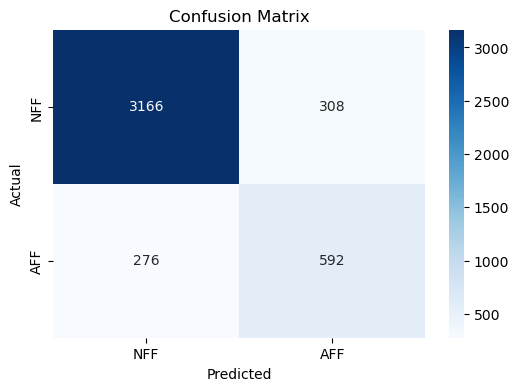

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3474
           1       0.66      0.68      0.67       868

    accuracy                           0.87      4342
   macro avg       0.79      0.80      0.79      4342
weighted avg       0.87      0.87      0.87      4342



{'Total Acc': 0.865,
 'nff Acc': 0.911,
 'aff Acc': 0.682,
 'AUC': 0.797,
 'MCC': 0.585,
 'F1 Score': 0.67}

In [16]:
model = res50
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet101

In [17]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')
# resnet50_metrics = test_model(model, test_dataset, batch_size=16)
# print(resnet50_metrics)


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 61.00%, Val ACC: 65.38%
Epoch 2/20, train ACC: 67.00%, Val ACC: 50.00%
Epoch 3/20, train ACC: 81.00%, Val ACC: 65.38%
Epoch 4/20, train ACC: 75.00%, Val ACC: 61.54%
Epoch 5/20, train ACC: 79.00%, Val ACC: 73.08%
Epoch 6/20, train ACC: 82.00%, Val ACC: 73.08%
Epoch 7/20, train ACC: 84.00%, Val ACC: 88.46%
Epoch 8/20, train ACC: 94.00%, Val ACC: 76.92%
Epoch 9/20, train ACC: 80.00%, Val ACC: 92.31%
Epoch 10/20, train ACC: 94.00%, Val ACC: 88.46%
Epoch 11/20, train ACC: 93.00%, Val ACC: 96.15%
Epoch 12/20, train ACC: 87.00%, Val ACC: 92.31%
Epoch 13/20, train ACC: 94.00%, Val ACC: 84.62%
Epoch 14/20, train ACC: 91.00%, Val ACC: 88.46%
Epoch 15/20, train ACC: 93.00%, Val ACC: 88.46%
Epoch 16/20, train ACC: 93.00%, Val ACC: 96.15%
Epoch 17/20, train ACC: 95.00%, Val ACC: 80.77%
Epoch 18/20, train ACC: 98.00%, Val ACC: 84.62%
Epoch 19/20, train ACC: 97.00%, Val ACC: 88.46%
Epoch 20/20, train ACC: 96.00%, Val ACC: 80.77%
Fold 2/5
Epoch 1/20, train ACC: 93.07%, 

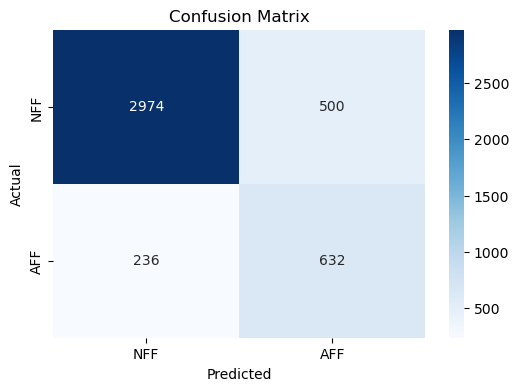

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      3474
           1       0.56      0.73      0.63       868

    accuracy                           0.83      4342
   macro avg       0.74      0.79      0.76      4342
weighted avg       0.85      0.83      0.84      4342



{'Total Acc': 0.83,
 'nff Acc': 0.856,
 'aff Acc': 0.728,
 'AUC': 0.792,
 'MCC': 0.532,
 'F1 Score': 0.632}

In [19]:
model = res50
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# DenseNet 161

In [20]:
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')
# densenet161_metrics = test_model(model, test_dataset, batch_size=16)
# print(densenet161_metrics)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 53.00%, Val ACC: 65.38%
Epoch 2/20, train ACC: 75.00%, Val ACC: 61.54%
Epoch 3/20, train ACC: 77.00%, Val ACC: 69.23%
Epoch 4/20, train ACC: 81.00%, Val ACC: 76.92%
Epoch 5/20, train ACC: 79.00%, Val ACC: 84.62%
Epoch 6/20, train ACC: 80.00%, Val ACC: 80.77%
Epoch 7/20, train ACC: 88.00%, Val ACC: 88.46%
Epoch 8/20, train ACC: 89.00%, Val ACC: 80.77%
Epoch 9/20, train ACC: 92.00%, Val ACC: 88.46%
Epoch 10/20, train ACC: 93.00%, Val ACC: 84.62%
Epoch 11/20, train ACC: 88.00%, Val ACC: 84.62%
Epoch 12/20, train ACC: 93.00%, Val ACC: 96.15%
Epoch 13/20, train ACC: 95.00%, Val ACC: 80.77%
Epoch 14/20, train ACC: 85.00%, Val ACC: 76.92%
Epoch 15/20, train ACC: 92.00%, Val ACC: 80.77%
Epoch 16/20, train ACC: 98.00%, Val ACC: 88.46%
Epoch 17/20, train ACC: 93.00%, Val ACC: 92.31%
Epoch 18/20, train ACC: 98.00%, Val ACC: 92.31%
Epoch 19/20, train ACC: 90.00%, Val ACC: 88.46%
Epoch 20/20, train ACC: 95.00%, Val ACC: 92.31%
Fold 2/5
Epoch 1/20, train ACC: 96.04%, 

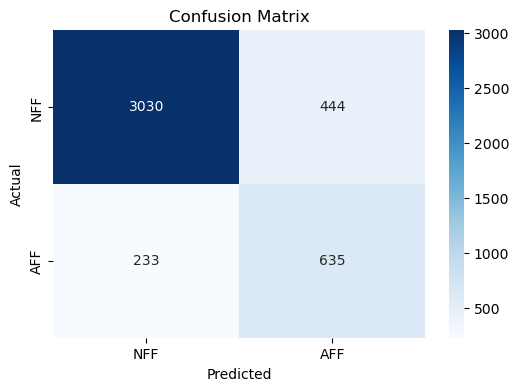

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3474
           1       0.59      0.73      0.65       868

    accuracy                           0.84      4342
   macro avg       0.76      0.80      0.78      4342
weighted avg       0.86      0.84      0.85      4342



{'Total Acc': 0.844,
 'nff Acc': 0.872,
 'aff Acc': 0.732,
 'AUC': 0.802,
 'MCC': 0.559,
 'F1 Score': 0.652}

In [21]:
model = dense161
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)